# Exploratory Data Analysis for soil samples

Author: Nafiseh Kakhani

Date : 05/08/2024

## 1. Intoduction
The purpose of this file is to explore the soil data and perform the necessary preprocessing. The provided dataset includes various data quality issues such as different date formats, outliers, and missing data. Therefore, we need to address each issue step by step.

In [1]:
from utils.utils import *

Reading data:

In [2]:
# Load the dataset
file_path = 'path/to/excel_file'
data = pd.read_excel(file_path)
data.head()

,X,Y,profile_id,profile_layer_id,country_name,upper_depth,lower_depth,layer_name,litter,orgc_value,orgc_value_avg,orgc_method,orgc_date,orgc_dataset_id,orgc_profile_code
0,4.666901,50.649889,36897,152510,Belgium,0,3,NaN,NaN,{1:11.30},11.3,"{""1:calculation = default correction factor fo...",{1:2012-3-22},BE-UplandsI,1170000000000
1,4.666901,50.649889,36897,152512,Belgium,3,6,NaN,NaN,{1:10.90},10.9,"{""1:calculation = default correction factor fo...",{1:2012-3-22},BE-UplandsI,1170000000000
2,4.666901,50.649889,36897,152513,Belgium,6,9,NaN,NaN,{1:11.70},11.7,"{""1:calculation = default correction factor fo...",{1:2012-3-22},BE-UplandsI,1170000000000
3,4.666901,50.649889,36897,152514,Belgium,9,12,NaN,NaN,{1:13.00},13.0,"{""1:calculation = default correction factor fo...",{1:2012-3-22},BE-UplandsI,1170000000000
4,4.666901,50.649889,36897,152517,Belgium,18,21,NaN,NaN,{1:10.60},10.6,"{""1:calculation = default correction factor fo...",{1:2012-3-22},BE-UplandsI,1170000000000


In the first step, we check for date inconsistencies, as this requires more effort than other issues.

In [3]:
# Convert dates to strings
data['orgc_date_str'] = data['orgc_date'].astype(str)

# Inspect unique formats
unique_formats = data['orgc_date_str'].unique()

# Count occurrences of each format
format_counts = data['orgc_date_str'].value_counts()

# Optional
# Display unique formats and their counts
print("Unique date formats and their counts:")
print(format_counts)  


Unique date formats and their counts:
orgc_date_str
{1:2012-4-18}                  341
{1:2012-4-5}                   336
{1:2012-3-22}                  307
{1:2012-3-16}                  267
{1:2012-4-13}                  262
{1:2012-4-12}                  221
{1:2012-3-15}                  185
{1:2012-4-30}                  173
{1:2011-10-7}                  162
{1:2012-4-26}                  160
{1:2012-5-3}                   155
{1:2012-3-23}                  154
{1:2011-10-14}                 146
{1:2012-5-4}                   132
{1:2011-10-6}                  125
{1:2012-4-20}                  114
{1:2011-10-21}                 109
{1:????-??-??}                 106
{1:2011-9-22}                   87
{1:2012-5-2}                    84
{1:2012-4-27}                   74
{1:2011-1-20}                   65
{1:2009-8-17}                   64
{1:2012-3-29}                   61
{1:2009-8-20}                   60
{1:2009-8-18}                   53
{1:2011-10-12}                  52
{1:

This issue will be addressed in the final preprocessing function called: `preprocess_data`.

In the next step, we create a histogram and KDE plot of the SOC values to ensure they are accurate.

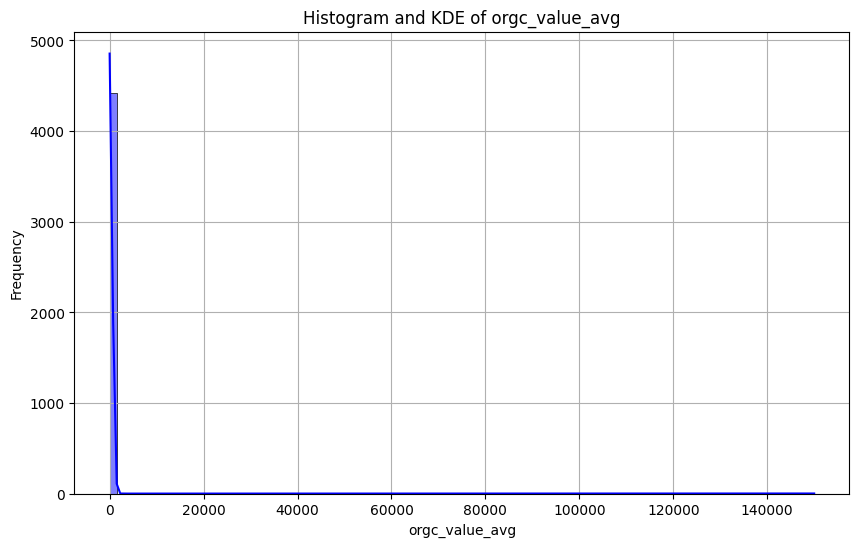

In [4]:
# Plot the Histogram and KDE after Preprocessing the Data
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='orgc_value_avg', kde=True, color='blue', bins=100)
plt.title('Histogram and KDE of orgc_value_avg')
plt.xlabel('orgc_value_avg')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The above figure clearly indicates the presence of outliers. Based on expert knowledge, we know that SOC stock values should not reach the excessively high levels shown in the plot. This suggests that some data points might be incorrect or need further checking. Therefore, we set a limit value of 600 and identify samples exceeding this threshold for further investigation.

In [5]:
# Print the values of orgc_value_avg greater than 600
omitted_values = data[data['orgc_value_avg'] > 600]
print("Values of orgc_value_avg greater than 600:")
pd.set_option('display.max_rows', None)  # Ensure all rows are displayed
print(omitted_values['orgc_value_avg'])

Values of orgc_value_avg greater than 600:
3826    150000.0
4162    123000.0
Name: orgc_value_avg, dtype: float64


In [6]:
data = data[(data['orgc_value_avg'] < 600) & (data['orgc_value_avg'].notna())]

Now, let us check the histogram and KDE plot agian: 

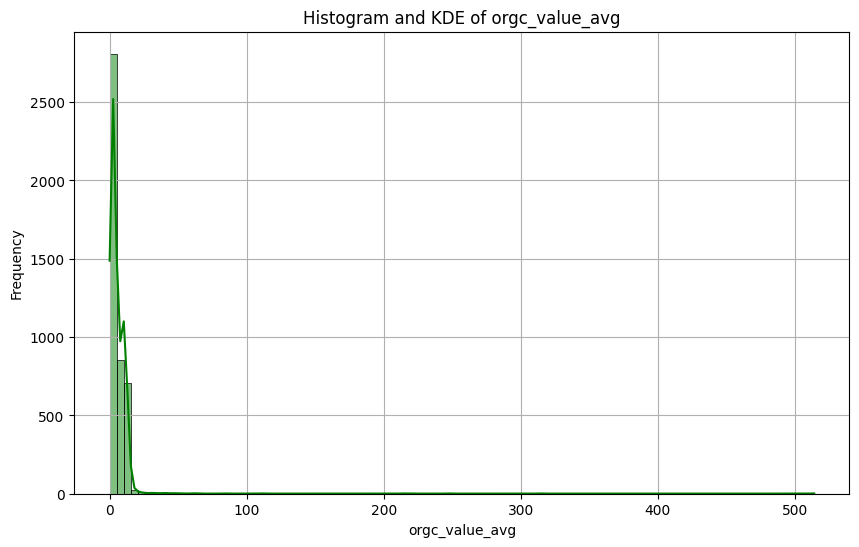

In [7]:
# Plot the Histogram and KDE after Preprocessing the Data
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='orgc_value_avg', kde=True, color='green', bins=100)
plt.title('Histogram and KDE of orgc_value_avg')
plt.xlabel('orgc_value_avg')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The above plot appears to be free of issues.
 
The above procedure will also be included in the `preprocess_data` function to ensure completeness.

## 2. Visualization and Insights

Since soil samples are always severely skewed (refer to [this study](https://www.mdpi.com/2072-4292/16/3/438)), we can go one step further and log-transform the data.

In [8]:
data ['orgc_value_avg'] = np.log(data ['orgc_value_avg'] + 1)

Let us display the histogram and KDE plot agian:

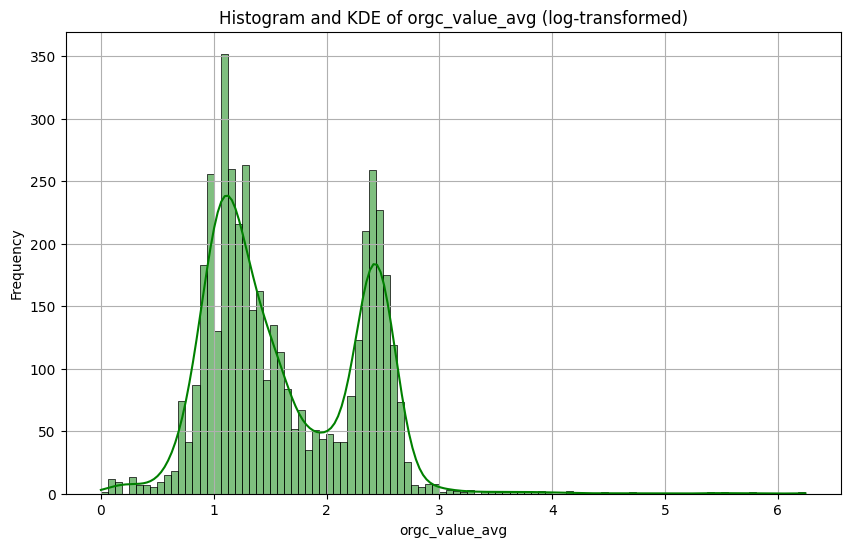

In [9]:
# Plot the Histogram and KDE after Preprocessing the Data
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='orgc_value_avg', kde=True, color='green', bins=100)
plt.title('Histogram and KDE of orgc_value_avg (log-transformed)')
plt.xlabel('orgc_value_avg')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The plot now helps us better understand the distribution of the data across the range. 

Next, we can plot the spatial distribution of the samples using `Geopandas` and `Folium`.

In [10]:
# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(data['X'], data['Y'])]
gdf = gpd.GeoDataFrame(data[['X', 'Y', 'orgc_value_avg']], geometry=geometry)

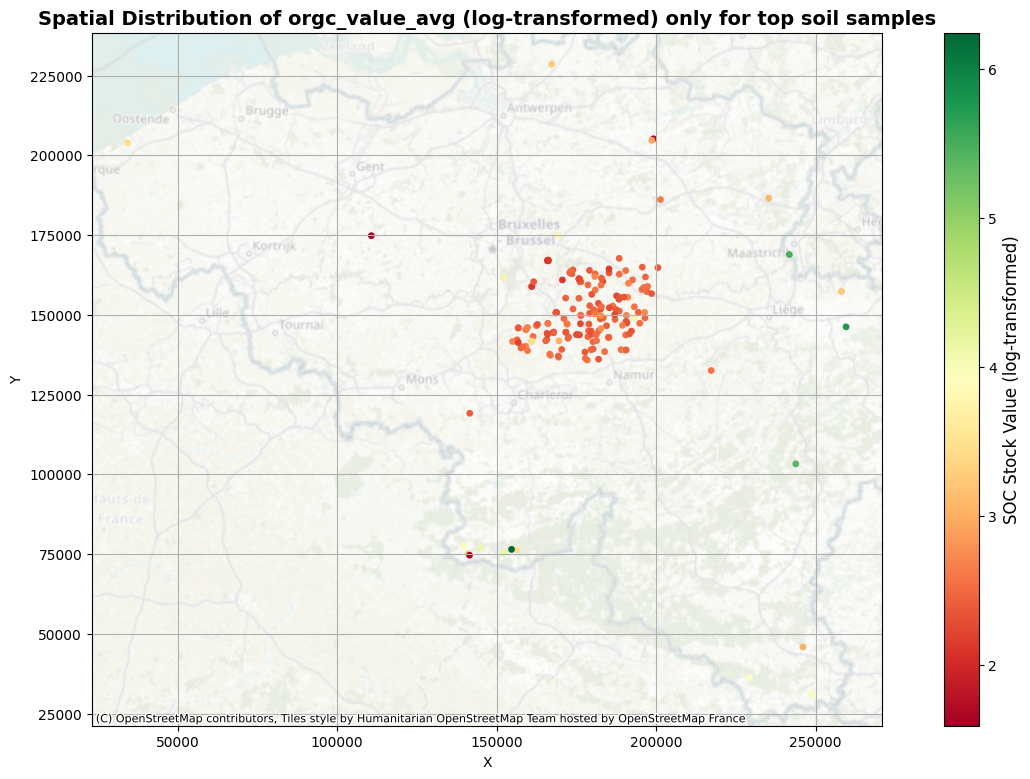

In [11]:
# Find the row with the lowest upper_depth for each profile_id
idx = data.groupby('profile_id')['upper_depth'].idxmin()
filtered_data = data.loc[idx]

# Create a GeoDataFrame for the filtered data
geometry = [Point(xy) for xy in zip(filtered_data['X'], filtered_data['Y'])]
gdf = gpd.GeoDataFrame(filtered_data, geometry=geometry)

# Set the coordinate reference system (CRS) for Belgium, EPSG:31370 for calculations
gdf.set_crs(epsg=4326, inplace=True)
gdf = gdf.to_crs(epsg=31370)

# Plot the data
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
gdf_plot = gdf.plot(column='orgc_value_avg', ax=ax, cmap='RdYlGn', markersize=15)

# Add a transparent base map
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.HOT, alpha=0.3)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=gdf['orgc_value_avg'].min(), vmax=gdf['orgc_value_avg'].max()))
sm._A = []
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label("SOC Stock Value (log-transformed)", fontsize=12)

# Customize the plot
plt.title('Spatial Distribution of orgc_value_avg (log-transformed) only for top soil samples', fontweight = 'bold', fontsize = 14)
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)

# Show the plot
plt.show()

We can go one step further and create an interactive map to explore the locations and values of soil samples.

In [12]:
gdf = gdf.to_crs(epsg=4326)

# Create a base map with attribution for Stamen Toner tiles
m = folium.Map(
    location=[50.70, 4.50],
    zoom_start=12,
    tiles='cartodb positron',
    attr='Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.'
)

# Add points to the map
marker_cluster = MarkerCluster().add_to(m)
for idx, row in gdf.iterrows():
    # Debug: Print marker coordinates
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=f"orgc_value_avg: {row['orgc_value_avg']}",
        icon=folium.Icon(color='red' if row['orgc_value_avg'] > 0 else 'blue')
    ).add_to(marker_cluster)

# Display the map
m.save('map.html')

# Open the map in the default web browser (optional, if you want to automatically open it)
import webbrowser
webbrowser.open('map.html')

True

Feel free to explore `map.html` to see the locations and values of SOC.

## 3. Summary

Finally, we address all the preprocessing steps in `utils.py`:

The code begins by importing essential libraries for data manipulation, date parsing, geospatial processing, and visualization, including `pandas`, `json`, `numpy`, `dateutil.parser`, `geopandas`, `matplotlib.pyplot`, `shapely.geometry.Point`, `contextily`, `seaborn`, `folium`, and `folium.plugins.MarkerCluster`.

The `extract_date` function extracts dates from dictionary-like strings, while `try_parse_date` attempts to convert these strings into datetime objects using multiple formats. The `preprocess_data` function is then defined to clean and preprocess the dataset. It converts date columns to a consistent datetime format, handles missing data by filling it with appropriate placeholder values, cleans the `orgc_method` column by ensuring it is in JSON format, and converts `profile_id` and `profile_layer_id` to integers and `orgc_profile_code` to a string. Additionally, the function omits rows where `lower_depth` is less than `upper_depth` to ensure data consistency, and it ensures that the values for `orgc_value_avg` are below 600.

Note: There are two columns called `layer_name` and `litter` which are completely empty. However, we choose to keep them since the data is part of a larger dataset, and these columns might be useful in the future.

Now we are ready to apply `preprocess_data` function: 

In [13]:
# Preprocess the data
clean_data = preprocess_data(data)
clean_data.head()

,X,Y,profile_id,profile_layer_id,country_name,upper_depth,lower_depth,layer_name,litter,orgc_value,orgc_value_avg,orgc_method,orgc_date,orgc_dataset_id,orgc_profile_code,orgc_date_str
0,4.666901,50.649889,36897,152510,Belgium,0,3,Same,Same,{1:11.30},2.509599,"{""1:calculation = default correction factor fo...",2012-03-22,BE-UplandsI,1170000000000,{1:2012-3-22}
1,4.666901,50.649889,36897,152512,Belgium,3,6,Same,Same,{1:10.90},2.476538,"{""1:calculation = default correction factor fo...",2012-03-22,BE-UplandsI,1170000000000,{1:2012-3-22}
2,4.666901,50.649889,36897,152513,Belgium,6,9,Same,Same,{1:11.70},2.541602,"{""1:calculation = default correction factor fo...",2012-03-22,BE-UplandsI,1170000000000,{1:2012-3-22}
3,4.666901,50.649889,36897,152514,Belgium,9,12,Same,Same,{1:13.00},2.639057,"{""1:calculation = default correction factor fo...",2012-03-22,BE-UplandsI,1170000000000,{1:2012-3-22}
4,4.666901,50.649889,36897,152517,Belgium,18,21,Same,Same,{1:10.60},2.451005,"{""1:calculation = default correction factor fo...",2012-03-22,BE-UplandsI,1170000000000,{1:2012-3-22}


And save the results:

In [14]:
# Save clean_data to a CSV file
output_file_path = 'clean_data.csv'
clean_data.to_csv(output_file_path, index=False)

print(f"Cleaned data saved to {output_file_path}")

Cleaned data saved to clean_data.csv


Continue to finish this project by running `main.py` to create a database from the clean data.

## End